In [1]:
# Selecting sub part of tensor and the indices of selected elements

In [1]:
import torch
from torchvision import models
import torch.nn as nn
from torch import FloatTensor
from torch.autograd import Variable
import shutil
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import resnet18
from graphviz import Digraph
from torchviz import make_dot

In [4]:
torch.__version__

'1.4.0'

In [3]:
A = torch.randint(0, 10, (10, 10))
idx = (A > 5).nonzero()

In [4]:
idx;

In [5]:
# Convert list of numbers to Tensor

In [6]:
# list_val=[2,5,7,3,2,4,2]
# list_val=torch.tensor(list_val)
# list_val=torch.Tensor(list_val)

In [8]:
# list_val

In [9]:
# Output from network varies depending on CPU or GPU

In [10]:
# for 3d array axis=0 means sum along channel, for 2d array sum=0 means sum along rows

In [11]:
# difference in CPU architecture between both posted CPUs might explain the difference

# Also, the implementation of the pseudo-random number generator might be different 
# for different hardware devices (e.g. CPU vs. GPU).

In [12]:
x = torch.randn((4, 3, 3))
s1 = x.sum()
s2 = x.sum(0).sum(0).sum(0)
print(s1 - s2,(s1 - s2).abs(),(s1 - s2).abs().max())

tensor(0.) tensor(0.) tensor(0.)


In [13]:
# ValueError: can’t optimize a non leaf Tensor?

In [14]:
# gradients can only be stored for leaf nodes, leaf nodes are those which are independent 
# and not the result of some comtutation like a, w1,w2,w3,w4 in below graph.

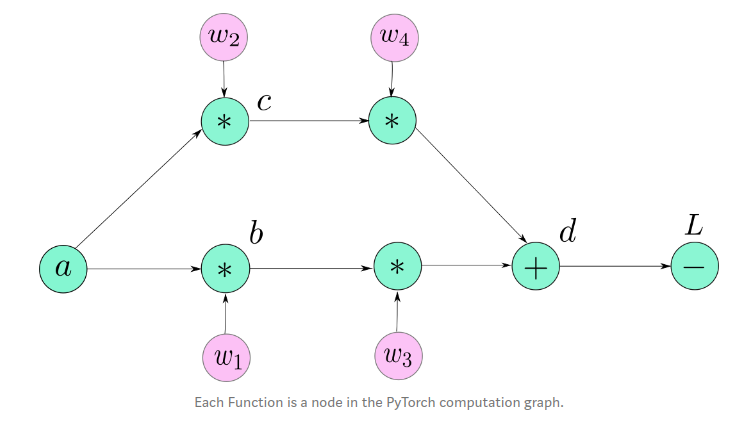

In [15]:
from IPython.display import Image
Image(filename='/home/persistance/Pictures/Screenshot from 2020-02-08 00-20-08.png')

In [16]:
a = torch.rand(10, requires_grad=True) # a is a leaf variable
# a = torch.rand(10, requires_grad=True).double() # a is NOT a leaf variable as it was created by the operation that cast a float tensor into a double tensor
# a = torch.rand(10).requires_grad_().double() # equivalent to the formulation just above: not a leaf variable
# a = torch.rand(10).double() # a does not require gradients and has not operation creating it (tracked by the autograd engine).
# a = torch.rand(10).double().requires_grad_() # a requires gradients and has no operations creating it: it's a leaf variable and can be given to an optimizer.
# a = torch.rand(10, requires_grad=True, device="cuda") # a requires grad, has not operation creating it: it's a leaf variable as well and can be given to an optimizer

a.sum().backward()

print (a.grad,a.is_leaf)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]) True


In [18]:
# using bwlow formula we need to create the graph
# b = w1 * a
# c = w2 * a 
# d = (w3 * b) + (w4 * c)
# L = f(d)

In [51]:
a=Variable(FloatTensor([4]))
weights= [Variable(FloatTensor([i]), requires_grad=True) for i in (2,5,9,7)]
w1,w2,w3,w4= weights

In [20]:
w1.requires_grad

True

In [21]:
# pytorch uses dynaic graph, when forwad is called then this graph is created as 
# we call backward gradiets are stored in the leaf node and this grap is destroyed. Calling two times backward
# we get below error

# RuntimeError: Trying to backward through the graph a second time,
# but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [22]:
b=w1*a
b.retain_grad()
c=w2*a
d= (w3*b) + (w4*c)
L=10-d

In [23]:
L.backward()
# L.backward()

In [24]:
for ind,wei in enumerate(weights):
    grad=wei.grad.data
    print (f'grads are w{ind} {grad}')

grads are w0 tensor([-36.])
grads are w1 tensor([-28.])
grads are w2 tensor([-8.])
grads are w3 tensor([-20.])


In [25]:
a.grad

In [26]:
# How to add a pretrained model into a new model class

In [66]:
resnet = models.resnet50(pretrained=True)
num_ftrs = resnet.fc.in_features
print(num_ftrs)

2048


In [65]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
resnet.fc=nn.Identity()
inp=torch.randn(1,3,214,214)
out=resnet(inp)
out.shape

torch.Size([1, 2048])

In [29]:
class FinetuneResnet(nn.Module):
    def __init__(self, resnet_pretrain, resnet_filter, num_classes):
        super(FinetuneResnet, self).__init__()
        self.resnet = resnet_pretrain
        self.fc1 = nn.Linear(resnet_filter, 2048)
        self.fc2 = nn.Linear(2048, num_classes)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.resnet(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.softmax(self.fc2(x))
        return x

In [30]:
model = FinetuneResnet(resnet, num_ftrs, 10)

In [59]:
# Basic unet architecture

In [15]:
class Unet(nn.Module):
    def __init__(self,inp,out):
        super().__init__()
        self.conv1=self._convolve(inp,16)
        self.conv2=self._convolve(16,32)
        self.conv3=self._convolve(32,64)
        
        self.maxpool=nn.MaxPool2d(2)
        self.upsample=nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True)
        
        self.conv_decode1=self._convolve(64+32,32)
        self.conv_decode2=self._convolve(32+16,16)
        self.final_conv=nn.Conv2d(16,1,1)
    
    def _convolve(self,inp,out,kernel=3):
        
        block=nn.Sequential(nn.Conv2d(inp,out,kernel_size=kernel,padding=1),
                            nn.ReLU(inplace=True),
                            nn.BatchNorm2d(out),
                            nn.Conv2d(out,out,kernel_size=kernel,padding=1),
                            nn.ReLU(inplace=True),
                            nn.BatchNorm2d(out))
        return block
    
    def forward(self,x):
        conv1 = self.conv1(x)
        x = self.maxpool(conv1)
        conv2 = self.conv2(x)
        x = self.maxpool(conv2)
        conv3 = self.conv3(x)
        x = self.upsample(conv3)
        x=torch.cat([x,conv2],axis=1)
        x=self.conv_decode1(x)
        x=self.upsample(x)
        x=torch.cat([x,conv1], axis=1)
        
        return x

In [16]:
net=Unet(1,3)

In [62]:
inpput_u=torch.randn(1,100,100)
inpput_u=inpput_u.unsqueeze(0)
inpput_u.shape

torch.Size([1, 1, 100, 100])

In [63]:
out=net(inpput_u)

In [ ]:
# An nn.Module class helps in managing the internal parameters and makes some workflows easier,
# e.g. pushing all parameters to the GPU by calling .to('cuda').

In [10]:
# how to change dtypes
ran=torch.randn(3,4).half()
ran.dtype

model.to(torch.double) #will convert all parameters to float64.

torch.float16

In [ ]:
# Saving & loading files in pytorch for resuming.

In [ ]:
# *******torch.save(the_model.state_dict(), PATH)
# *******the_model = TheModelClass(*args, **kwargs)
# *******the_model.load_state_dict(torch.load(PATH))
# only its parameters get pickled.

# *******torch.save(the_model, PATH)
# *******the_model = torch.load(PATH)
# Here whole object gets pickled,

In [47]:
best_acc1 = 0.78   #starts with 0 and keep on updating if current accuracy is greater tha previous one.
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
acc1 = 0.62  #validation accuracy

is_best = acc1 > best_acc1
best_acc1 = max(acc1, best_acc1)

save_checkpoint({
    'epoch': 1,
    'arch': net,
    'state_dict': net.state_dict(),
    'best_prec1': best_acc1,
    'optimizer' : optimizer.state_dict(),
}, is_best)

In [46]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [49]:
if os.path.isfile('checkpoint.pth.tar'):
    print("=> loading checkpoint '{}'".format('checkpoint.pth.tar'))
    checkpoint = torch.load('checkpoint.pth.tar')
    start_epoch = checkpoint['epoch']
    best_prec1 = checkpoint['best_prec1']
    net.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print("=> loaded checkpoint '{}' (epoch {})"
          .format('checkpoint.pth.tar', checkpoint['epoch']))
else:
    print("=> no checkpoint found at '{}'".format('checkpoint.pth.tar'))

=> loading checkpoint 'checkpoint.pth.tar'
=> loaded checkpoint 'checkpoint.pth.tar' (epoch 1)


In [129]:
# weight initialization pytorch

In [87]:
resnet = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/persistance/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [88]:
resnet.conv1.weight.mean(), resnet.conv1.weight.std()

(tensor(-0.0001, grad_fn=<MeanBackward0>),
 tensor(0.1231, grad_fn=<StdBackward0>))

In [124]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight.data)

def weights_init1(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data)

In [125]:
resnet.apply(weights_init);

In [126]:
resnet.conv1.weight.mean(), resnet.conv1.weight.std()

(tensor(0.0009, grad_fn=<MeanBackward0>),
 tensor(0.1179, grad_fn=<StdBackward0>))

In [ ]:
# extract features of an image from a trained model

In [2]:
resnet=resnet18(pretrained=True)

In [3]:
class Classifer(nn.Module):
    def __init__(self, arc):
        super().__init__()
        self.new_classifer=nn.Sequential(*list(arc.children())[:-1])

    def forward(self, x):
        out=self.new_classifer(x)
        out=out.view(-1,out.numel())
        out=nn.Linear(512,1000)(out)
        return out

In [4]:
net=Classifer(resnet)

In [5]:
inp=torch.randn(3,214,214)
inp=inp.unsqueeze(0)

In [6]:
result=net(inp)

In [92]:
class FeatureExtractor(nn.Module):
    def __init__(self, submodule, extracted_layers):
        super().__init__()
        self.submodule = nn.Sequential(*list(submodule.children())[:-1])
        self.extracted_layers=extracted_layers

    def forward(self, x):
        outputs = []
        for name, module in self.submodule._modules.items():
            x = module(x)
            if name in self.extracted_layers:
                outputs += [x]
        return outputs + [x]

In [93]:
tes=FeatureExtractor(resnet,['conv1'])

In [94]:
tes1=tes(inp)

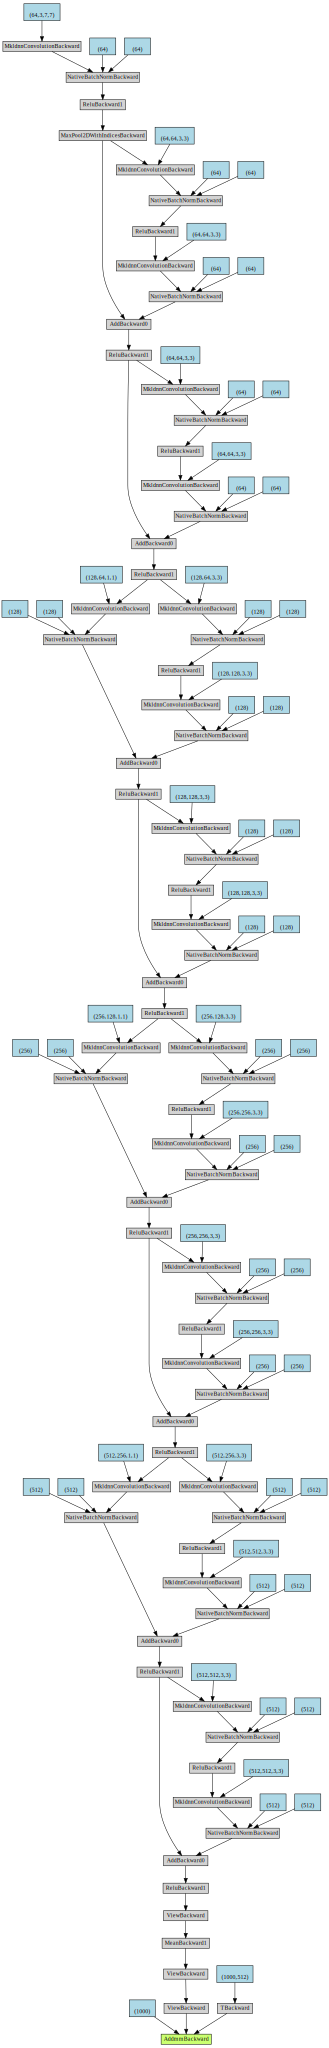

In [95]:
make_dot(result)